In [1]:
import json
import pandas as pd
import nibabel as nib
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
plt.style.use("bmh")
plt.rcParams["figure.dpi"] = 150

In [3]:
metadata_path = Path("../metadata")
# download raw data from abide s3 bucket first
rawdataBIDS_path = Path("../data/RawDataBIDS")
# download fmriprep data from medarc r2 bucketfirst
fmriprep_path = Path("../data/fmriprep")

### Checking fmri runs

- first index all image metadata, getting shape, tr, run length

In [4]:
def parse_metadata(path: Path):
    # poor persons bids parser
    # CMU_a/sub-0050642/anat/sub-0050642_T1w.nii.gz
    dataset = path.parts[-4]
    site = dataset.split("_")[0]  # CMU_a -> CMU
    stem, ext = path.name.split(".", 1)
    stem, suffix = stem.rsplit("_", 1)
    meta = dict(item.split("-") for item in stem.split("_") if "-" in item)
    # set sometimes missing keys
    for k in ["task", "run"]:
        meta[k] = meta.get(k)
    meta = {"site": site, "dataset": dataset, **meta, "suffix": suffix}
    return meta


def read_header(path: Path):
    img = nib.load(path, mmap=True)
    shape = list(img.shape)
    pixdim = [round(v, 2) for v in img.header["pixdim"][1:4].tolist()]
    if len(shape) == 4:
        tr = round(float(img.header["pixdim"][4]), 2)
        num_trs = shape[-1]
        dur = num_trs * tr
        shape = shape[:3]
    else:
        tr = num_trs = dur = None
    info = {"shape": shape, "pixdim": pixdim, "tr": tr, "num_trs": num_trs, "dur": dur}
    return info


bids_index_path = Path("../metadata/ABIDE_BIDS_index.csv")

if not bids_index_path.exists():
    bids_path_list = sorted(rawdataBIDS_path.rglob("*.nii.gz"))
    records = []
    for path in tqdm(bids_path_list):
        relpath = str(path.relative_to(rawdataBIDS_path))
        meta = parse_metadata(path)
        info = read_header(path)
        records.append({**meta, **info, "path": relpath})
    bids_index_df = pd.DataFrame.from_records(records)
    bids_index_df.to_csv(bids_index_path, index=False)
bids_index_df = pd.read_csv(bids_index_path, dtype={"sub": str})

In [5]:
print(
    bids_index_df.shape,
    bids_index_df["sub"].nunique(),
    (bids_index_df["suffix"] == "bold").sum(),
    (bids_index_df["suffix"] == "T1w").sum(),
)
bids_index_df.head()

(2265, 12) 1112 1163 1102


,site,dataset,sub,task,run,suffix,shape,pixdim,tr,num_trs,dur,path
0,CMU,CMU_a,0050642,NaN,NaN,T1w,"[170, 217, 151]","[1.0, 1.0, 1.0]",NaN,NaN,NaN,CMU_a/sub-0050642/anat/sub-0050642_T1w.nii.gz
1,CMU,CMU_a,0050642,rest,1.0,bold,"[64, 64, 28]","[3.0, 3.0, 4.5]",2.0,240.0,480.0,CMU_a/sub-0050642/func/sub-0050642_task-rest_r...
2,CMU,CMU_a,0050646,NaN,NaN,T1w,"[173, 228, 200]","[1.0, 1.0, 1.0]",NaN,NaN,NaN,CMU_a/sub-0050646/anat/sub-0050646_T1w.nii.gz
3,CMU,CMU_a,0050646,rest,1.0,bold,"[64, 64, 28]","[3.0, 3.0, 4.5]",2.0,240.0,480.0,CMU_a/sub-0050646/func/sub-0050646_task-rest_r...
4,CMU,CMU_a,0050647,NaN,NaN,T1w,"[169, 215, 200]","[1.0, 1.0, 1.0]",NaN,NaN,NaN,CMU_a/sub-0050647/anat/sub-0050647_T1w.nii.gz


- 1112 subjects, 1163 bold, 1102 t1w

In [6]:
# only need bold for now
bids_bold_df = bids_index_df.loc[bids_index_df["suffix"] == "bold"]

In [7]:
# check amount of data per site
print(bids_bold_df.groupby(["site"]).agg({"sub": "nunique", "path": "count"}))

          sub  path
site               
CMU        27    27
Caltech    38    38
KKI        55    55
Leuven     64    64
MaxMun     57    57
NYU       184   184
OHSU       28    79
Olin       36    36
Pitt       57    57
SBL        30    30
SDSU       36    36
Stanford   40    40
Trinity    49    49
UCLA      109   109
UM        145   145
USM       101   101
Yale       56    56


- all sites have one run per sub except OHSU

In [8]:
# check scan durations
print(bids_bold_df.groupby(["site", "dur"]).agg({"path": "count"}))

                path
site     dur        
CMU      412.0     1
         480.0    26
Caltech  300.0    38
KKI      320.0     6
         355.0     1
         390.0    48
Leuven   412.5    32
         415.0     1
         417.5    31
MaxMun   360.0    41
         600.0    16
NYU      360.0   184
OHSU     205.0    79
Olin     315.0    36
Pitt     300.0    57
SBL      440.0    30
SDSU     360.0    36
Stanford 360.0    17
         362.0     1
         476.0     2
         480.0    20
Trinity  300.0    49
UCLA     360.0   109
UM       600.0   145
USM      472.0     1
         480.0   100
Yale     400.0    56


- all sites have scans >= 5 min except OHSU. ig OHSU splits their sessions into shorter runs.
- all sites have scans <= 8 min except UM and MaxMun

In [9]:
# check for preprocessed outputs
bids_bold_df.loc[:, ["has_cifti"]] = False
bids_bold_df.loc[:, ["has_mni"]] = False

for ii, row in bids_bold_df.iterrows():
    if row["suffix"] == "bold":
        path = row["path"]
        cifti_path = path.replace("_bold.nii.gz", "_space-fsLR_den-91k_bold.dtseries.nii")
        mni_path = path.replace(
            "_bold.nii.gz", "_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz"
        )
        bids_bold_df.loc[ii, "has_cifti"] = (fmriprep_path / cifti_path).exists()
        bids_bold_df.loc[ii, "has_mni"] = (fmriprep_path / mni_path).exists()

In [10]:
# check completion fraction for all sites
print(bids_bold_df.groupby("site").agg({"has_cifti": ["sum", "mean"], "has_mni": ["sum", "mean"]}))

         has_cifti           has_mni          
               sum      mean     sum      mean
site                                          
CMU             27  1.000000      27  1.000000
Caltech         38  1.000000      38  1.000000
KKI             55  1.000000      55  1.000000
Leuven          64  1.000000      64  1.000000
MaxMun          57  1.000000      57  1.000000
NYU            184  1.000000     184  1.000000
OHSU            79  1.000000      79  1.000000
Olin            36  1.000000      36  1.000000
Pitt            57  1.000000      57  1.000000
SBL             30  1.000000      30  1.000000
SDSU            36  1.000000      36  1.000000
Stanford        40  1.000000      40  1.000000
Trinity         49  1.000000      49  1.000000
UCLA            99  0.908257      99  0.908257
UM             144  0.993103     143  0.986207
USM            101  1.000000     100  0.990099
Yale            56  1.000000      56  1.000000


- most sites are complete except for UCLA, UM, USM. tbd what happened with their preprocessing/upload.

In [11]:
bids_bold_df.loc[:, ["run_ok"]] = (
    (bids_bold_df["dur"] >= 5 * 60)  # at least 5 min duration
    & (bids_bold_df["has_cifti"])  # complete cifti output
    & (bids_bold_df["has_mni"])  # complete mni output
)
print(bids_bold_df["run_ok"].sum(), len(bids_bold_df))

1071 1163


- 1071 runs pass out of 1163

### Checking subjects

In [12]:
preprocessed_ABIDE = pd.read_csv(f"{metadata_path}/Phenotypic_V1_0b_preprocessed.csv", index_col=0)
preprocessed_ABIDE = preprocessed_ABIDE.reset_index(drop=True)
preprocessed_ABIDE.insert(0, "sub", [f"{subid:07d}" for subid in preprocessed_ABIDE["SUB_ID"]])
preprocessed_ABIDE.head(5)

,sub,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,...,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3
0,0050002,50002,1,50002,PITT,no_filename,1,1,16.77,1,...,fail,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24
1,0050003,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
2,0050004,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
3,0050005,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,...,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN
4,0050006,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,...,OK,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN


Text(0.5, 0, 'Subject (sorted)')

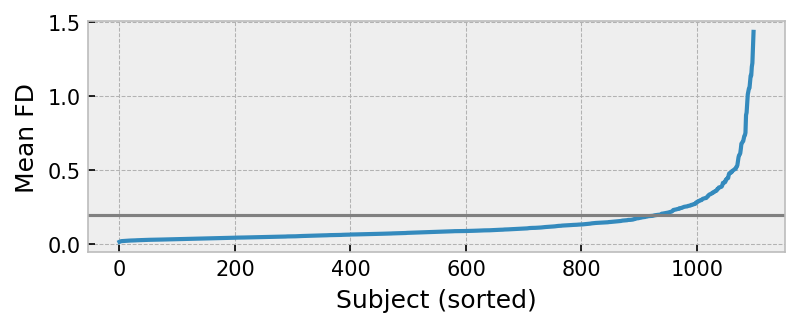

In [13]:
plt.figure(figsize=(6, 2))
plt.plot(np.sort(preprocessed_ABIDE["func_mean_fd"]))
plt.axhline(0.2, color="gray", lw=1.5)
plt.ylabel("Mean FD")
plt.xlabel("Subject (sorted)")

- typical mean fd 0.2 seems like reasonable cutoff

In [14]:
print(preprocessed_ABIDE["qc_rater_1"].value_counts())

qc_rater_1
OK       997
fail     111
maybe      4
Name: count, dtype: int64


- take qc rater 1's word for it i guess

In [15]:
# Keep only those where QC rater 1 agreed the data is 'OK'
preprocessed_ABIDE_clean = preprocessed_ABIDE[(preprocessed_ABIDE["qc_rater_1"] == "OK")]

# Apply Motion Threshold (Mean FD < 0.2mm)
preprocessed_ABIDE_clean = preprocessed_ABIDE_clean[preprocessed_ABIDE_clean["func_mean_fd"] < 0.2]

include_subs = preprocessed_ABIDE_clean["sub"]
print(len(include_subs), len(preprocessed_ABIDE))

853 1112


- 853 subjects pass out of 1112

### Check sites

Drop sites that don't have enough data after filtering runs and subjects

In [16]:
bids_bold_df.loc[:, ["sub_ok"]] = bids_bold_df["sub"].isin(include_subs)
print(bids_bold_df.loc[bids_bold_df["sub_ok"], "sub"].nunique())

853


In [17]:
site_counts = (
    bids_bold_df.loc[bids_bold_df["run_ok"] & bids_bold_df["sub_ok"]]
    .groupby("site")
    .agg({"sub": "nunique", "path": "count"})
)
print(site_counts)

          sub  path
site               
CMU         3     3
Caltech    22    22
KKI        39    39
Leuven     56    56
MaxMun     42    42
NYU       170   170
Olin       25    25
Pitt       43    43
SBL        26    26
SDSU       31    31
Stanford   34    34
Trinity    44    44
UCLA       75    75
UM        111   111
USM        60    60
Yale       48    48


In [18]:
include_sites = sorted(site_counts.loc[site_counts["sub"] >= 20].index)
drop_sites = np.setdiff1d(bids_bold_df["site"].unique(), include_sites)
print(len(include_sites), bids_bold_df["site"].nunique(), drop_sites)

15 17 ['CMU' 'OHSU']


- all sites have enough data remaining except for CMU (and OHSU, excluded earlier and not shown)

In [19]:
bids_bold_df.loc[:, ["site_ok"]] = bids_bold_df["site"].isin(include_sites)

In [20]:
bids_bold_df.head()

,site,dataset,sub,task,run,suffix,shape,pixdim,tr,num_trs,dur,path,has_cifti,has_mni,run_ok,sub_ok,site_ok
1,CMU,CMU_a,0050642,rest,1.0,bold,"[64, 64, 28]","[3.0, 3.0, 4.5]",2.0,240.0,480.0,CMU_a/sub-0050642/func/sub-0050642_task-rest_r...,True,True,True,False,False
3,CMU,CMU_a,0050646,rest,1.0,bold,"[64, 64, 28]","[3.0, 3.0, 4.5]",2.0,240.0,480.0,CMU_a/sub-0050646/func/sub-0050646_task-rest_r...,True,True,True,False,False
5,CMU,CMU_a,0050647,rest,1.0,bold,"[64, 64, 28]","[3.0, 3.0, 4.5]",2.0,206.0,412.0,CMU_a/sub-0050647/func/sub-0050647_task-rest_r...,True,True,True,False,False
7,CMU,CMU_a,0050649,rest,1.0,bold,"[64, 64, 28]","[3.0, 3.0, 4.5]",2.0,240.0,480.0,CMU_a/sub-0050649/func/sub-0050649_task-rest_r...,True,True,True,True,False
9,CMU,CMU_a,0050653,rest,1.0,bold,"[64, 64, 28]","[3.0, 3.0, 4.5]",2.0,240.0,480.0,CMU_a/sub-0050653/func/sub-0050653_task-rest_r...,True,True,True,False,False


In [21]:
# final list of include runs
bids_include_df = bids_bold_df.loc[
    (bids_bold_df["run_ok"]) & (bids_bold_df["sub_ok"]) & (bids_bold_df["site_ok"])
]
print(bids_include_df.shape)
print(
    bids_include_df.groupby("site").agg(
        {"sub": "nunique", "path": "count", "tr": "mean", "num_trs": "mean", "dur": "mean"}
    )
)

(826, 17)
          sub  path        tr     num_trs         dur
site                                                 
Caltech    22    22  2.000000  150.000000  300.000000
KKI        39    39  2.500000  153.128205  382.820513
Leuven     56    56  1.660893  250.000000  415.223214
MaxMun     42    42  3.000000  137.142857  411.428571
NYU       170   170  2.000000  180.000000  360.000000
Olin       25    25  1.500000  210.000000  315.000000
Pitt       43    43  1.500000  200.000000  300.000000
SBL        26    26  2.200000  200.000000  440.000000
SDSU       31    31  2.000000  180.000000  360.000000
Stanford   34    34  2.000000  215.205882  430.411765
Trinity    44    44  2.000000  150.000000  300.000000
UCLA       75    75  3.000000  120.000000  360.000000
UM        111   111  2.000000  300.000000  600.000000
USM        60    60  2.000000  239.933333  479.866667
Yale       48    48  2.000000  200.000000  400.000000


In [22]:
include_subs_final = bids_include_df["sub"].unique()
include_sites_final = bids_include_df["site"].unique()
print(len(include_subs_final), len(include_sites_final))

826 15


### Construct splits

In [23]:
# get phenotype data
abide_pheno_df = preprocessed_ABIDE_clean.loc[
    :, ["sub", "SITE_ID", "DX_GROUP", "SEX", "AGE_AT_SCAN"]
]
abide_pheno_df = abide_pheno_df.loc[abide_pheno_df["sub"].isin(include_subs_final)]
abide_pheno_df = abide_pheno_df.reset_index(drop=True)
print(abide_pheno_df.shape)
abide_pheno_df.head()

(826, 5)


,sub,SITE_ID,DX_GROUP,SEX,AGE_AT_SCAN
0,0050004,PITT,1,1,19.09
1,0050005,PITT,1,2,13.73
2,0050006,PITT,1,1,13.37
3,0050007,PITT,1,1,17.78
4,0050008,PITT,1,1,32.45


In [24]:
abide_pheno_df.groupby(["DX_GROUP", "SEX"]).agg({"sub": "count"})

sub
DX_GROUP SEX     
1        1    324
         2     47
2        1    369
         2     86

- note, many more male (1) than female (2). ig bc asd is male biased, and they wanted matched groups.

ABIDE curation by Age, Gender (Sex), and Clinical Data (Diagnosis)

In [25]:
# Create Age Bins
# Split Age into 3 quantiles
# 3 bins works out nicely into kids, adolescent, adults
abide_pheno_df["age_bin"], bins = pd.qcut(
    abide_pheno_df["AGE_AT_SCAN"].round(), q=3, labels=["Q1", "Q2", "Q3"], retbins=True
)

# Create a Combined Stratification Column
# Format: [AgeBin]_[Sex]_[Diagnosis]
abide_pheno_df["strat_key"] = (
    abide_pheno_df["age_bin"].astype(str)
    + "_"
    + abide_pheno_df["SEX"].astype(str)
    + "_"
    + abide_pheno_df["DX_GROUP"].astype(str)
)

# Perform the Split (70% Train, 15% Val, 15% Test)
# First split: 70% Train, 30% Temp (which will be Val + Test)
train_df, temp_df = train_test_split(
    abide_pheno_df, test_size=0.30, random_state=42, stratify=abide_pheno_df["strat_key"]
)

# Second split: Divide the 30% Temp into 50/50 Val and Test
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df["strat_key"]
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 578 | Val: 124 | Test: 124


In [26]:
print(abide_pheno_df["strat_key"].value_counts().sort_index())

strat_key
Q1_1_1    120
Q1_1_2    133
Q1_2_1     21
Q1_2_2     38
Q2_1_1    102
Q2_1_2    120
Q2_2_1     16
Q2_2_2     33
Q3_1_1    102
Q3_1_2    116
Q3_2_1     10
Q3_2_2     15
Name: count, dtype: int64


In [27]:
print("--- Age Quantile Ranges ---")
for i in range(len(bins) - 1):
    print(f"Q{i + 1}: {bins[i]:.2f} to {bins[i + 1]:.2f} years")

abide_pheno_df.age_bin.value_counts()

--- Age Quantile Ranges ---
Q1: 6.00 to 13.00 years
Q2: 13.00 to 18.00 years
Q3: 18.00 to 64.00 years


age_bin
Q1    312
Q2    271
Q3    243
Name: count, dtype: int64

                 mean       std   min   max  count
Set                                               
Test        17.162961  8.306566  7.26  58.0    124
Train       17.076837  7.795796  6.47  64.0    578
Validation  17.021681  7.993210  7.19  52.0    124


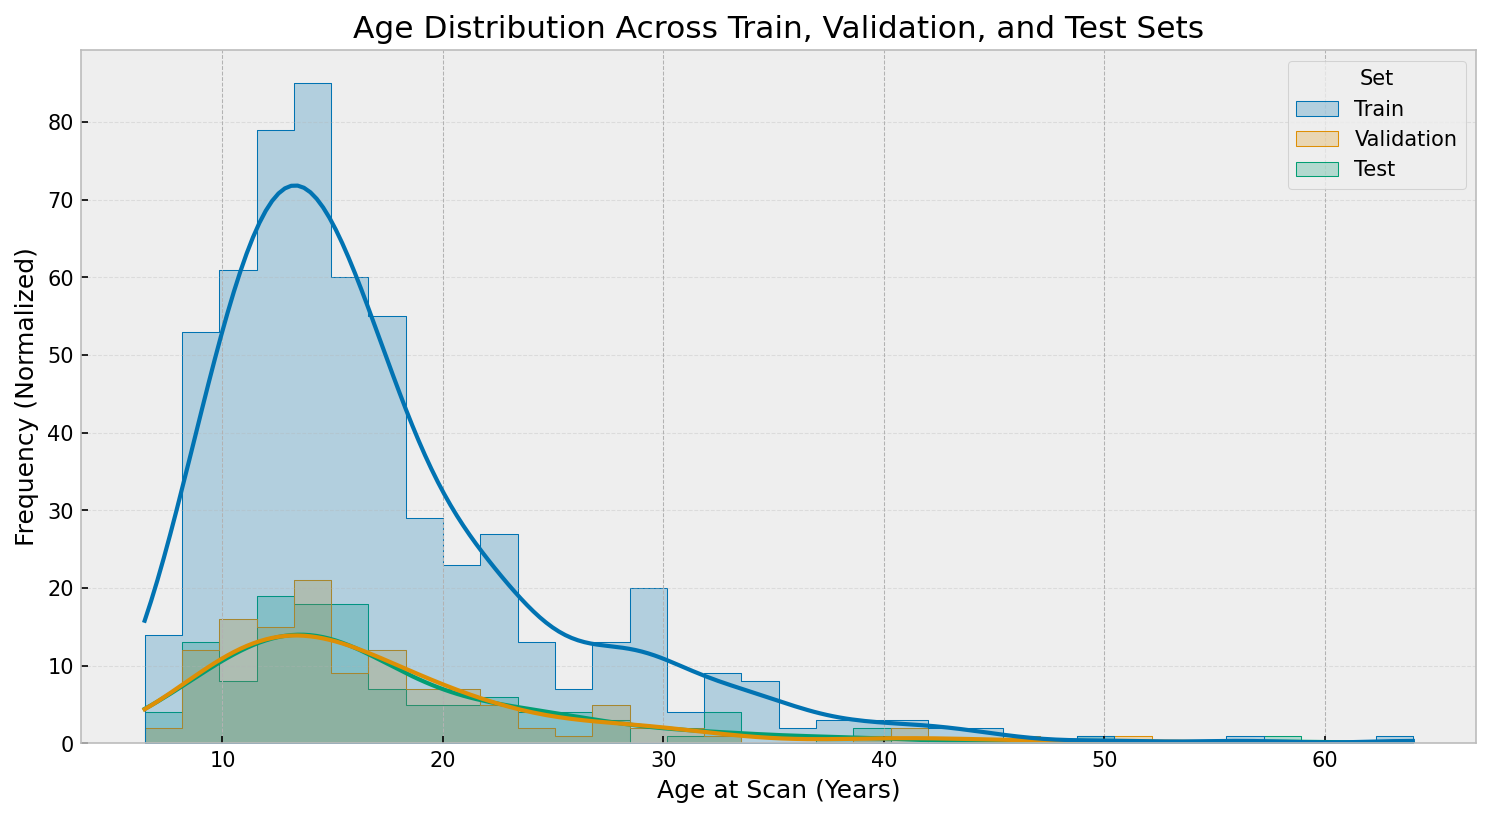

In [28]:
# Prepare data for visualization
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"

combined_df = pd.concat([train_df, val_df, test_df])

# Plotting
plt.figure(figsize=(12, 6))

# Histogram/KDE plot
sns.histplot(
    data=combined_df,
    x="AGE_AT_SCAN",
    hue="Set",
    element="step",
    kde=True,
    palette="colorblind",
    common_norm=False,
)

plt.title("Age Distribution Across Train, Validation, and Test Sets", fontsize=15)
plt.xlabel("Age at Scan (Years)", fontsize=12)
plt.ylabel("Frequency (Normalized)", fontsize=12)
plt.grid(axis="y", alpha=0.3)

# Summary stats to print
summary_stats = combined_df.groupby("Set")["AGE_AT_SCAN"].agg(
    ["mean", "std", "min", "max", "count"]
)
print(summary_stats)

In [29]:
combined_df.head()

,sub,SITE_ID,DX_GROUP,SEX,AGE_AT_SCAN,age_bin,strat_key,Set
551,0051070,NYU,2,1,7.2900,Q1,Q1_1_2,Train
395,0050741,LEUVEN_2,2,1,14.2000,Q2,Q2_1_2,Train
30,0050042,PITT,2,1,33.1700,Q3,Q3_1_2,Train
272,0050486,USM,1,1,17.7878,Q2,Q2_1_1,Train
120,0050257,TRINITY,2,1,14.9100,Q2,Q2_1_2,Train


In [30]:
# standardize
# see ABIDE data legend
# http://fcon_1000.projects.nitrc.org/indi/abide/ABIDE_LEGEND_V1.02.pdf
combined_df_std = combined_df.copy()
combined_df_std["sex"] = combined_df_std["SEX"].map({1: "Male", 2: "Female"})
combined_df_std["dx"] = combined_df_std["DX_GROUP"].map({1: "Autism", 2: "Control"})
combined_df_std["age_at_scan"] = combined_df_std["AGE_AT_SCAN"]

combined_df_std["split"] = pd.Categorical(
    combined_df_std["Set"].str.lower(), categories=["train", "validation", "test"], ordered=True
)

site_df = bids_include_df.loc[:, ["sub", "site", "dataset"]].drop_duplicates(inplace=False)
combined_df_std = combined_df_std.merge(site_df, on="sub", how="left")

combined_df_std = combined_df_std.loc[
    :, ["split", "site", "dataset", "sub", "dx", "sex", "age_at_scan", "age_bin", "strat_key"]
]
combined_df_std = combined_df_std.sort_values(["split", "sub"]).reset_index(drop=True)
print(combined_df_std.shape)
print(combined_df_std.isna().any())
combined_df_std.head()

(826, 9)
split          False
site           False
dataset        False
sub            False
dx             False
sex            False
age_at_scan    False
age_bin        False
strat_key      False
dtype: bool


,split,site,dataset,sub,dx,sex,age_at_scan,age_bin,strat_key
0,train,Pitt,Pitt,0050004,Autism,Male,19.09,Q3,Q3_1_1
1,train,Pitt,Pitt,0050005,Autism,Female,13.73,Q2,Q2_2_1
2,train,Pitt,Pitt,0050006,Autism,Male,13.37,Q1,Q1_1_1
3,train,Pitt,Pitt,0050007,Autism,Male,17.78,Q2,Q2_1_1
4,train,Pitt,Pitt,0050008,Autism,Male,32.45,Q3,Q3_1_1


In [31]:
print(combined_df_std.groupby(["split", "dx"], observed=True).agg({"sub": "count"}))
print(combined_df_std.groupby(["split", "sex"], observed=True).agg({"sub": "count"}))
print(combined_df_std.groupby(["split", "age_bin"], observed=True).agg({"sub": "count"}))

                    sub
split      dx          
train      Autism   259
           Control  319
validation Autism    56
           Control   68
test       Autism    56
           Control   68
                   sub
split      sex        
train      Female   94
           Male    484
validation Female   20
           Male    104
test       Female   19
           Male    105
                    sub
split      age_bin     
train      Q1       219
           Q2       189
           Q3       170
validation Q1        47
           Q2        41
           Q3        36
test       Q1        46
           Q2        41
           Q3        37


### Save outputs

In [32]:
combined_df_std.to_csv(metadata_path / "ABIDE_curated.csv", index=False)
np.savetxt(metadata_path / "ABIDE_curated_paths.txt", bids_include_df["path"], fmt="%s")

In [33]:
# save targets
target_root = metadata_path / "targets"
target_root.mkdir(exist_ok=True)
for target in ["dx", "sex", "age_bin"]:
    targets = {sub: label for sub, label in zip(combined_df_std["sub"], combined_df_std[target])}
    with (target_root / f"abide_target_map_{target}.json").open("w") as f:
        print(json.dumps(targets, indent=4), file=f)